In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

def detect_turning_events(df, threshold=0):
    """Detect turning events based on the change in horizontal position of shoulders."""
    # Calculate the Euclidean distance between left and right shoulder keypoints
    df['shoulder_distance'] = np.sqrt((df['RShoulder_x'] - df['LShoulder_x'])**2 + (df['RShoulder_y'] - df['LShoulder_y'])**2)

    # Identify turning events based on a threshold
    df['turning_event'] = df['shoulder_distance'].gt(threshold)

    # Filter rows with turning events
    turning_events = df[df['turning_event']]

    return turning_events



Mounted at /content/drive


In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/FYP/FYP_dataset/output_file.csv')

# Filter the DataFrame for the specific file_name and select relevant columns
df = df[df['file_name'] == 'PD_front_2.json']

# Set the threshold for turning detection (adjust as needed)
distance_threshold = 0

# Detect turning events
turning_events = detect_turning_events(df, threshold=distance_threshold)

# Calculate the time duration for each row based on the assumption of a constant time interval
total_rows = len(df)  # Replace with the actual total number of rows
total_duration_seconds = 61.0  # Replace with the actual total duration of the video in seconds

# Calculate the time duration for each row
time_interval = total_duration_seconds / total_rows

# Add a 'time_duration' column to the turning events DataFrame
turning_events['time_duration'] = turning_events.index * time_interval

# Print the resulting DataFrame with the estimated time duration
print(turning_events[['file_name', 'time_duration']])

             file_name  time_duration
21948  PD_front_2.json     724.082207
21949  PD_front_2.json     724.115197
21950  PD_front_2.json     724.148188
21951  PD_front_2.json     724.181179
21952  PD_front_2.json     724.214170
...                ...            ...
23792  PD_front_2.json     784.917253
23793  PD_front_2.json     784.950243
23794  PD_front_2.json     784.983234
23795  PD_front_2.json     785.016225
23796  PD_front_2.json     785.049216

[1849 rows x 2 columns]


In [4]:
if 700 < len(turning_events['time_duration']) < 1000:
  distance_value = 30

elif 1000 < len(turning_events['time_duration']) < 1500:
  distance_value = 60

elif 1500 < len(turning_events['time_duration']) < 2000:
  distance_value = 100

elif 700 > len(turning_events['time_duration']):
  distance_value = 20


In [5]:
sd = []  # Initialize an empty list to store shoulder_distance values
sd.extend(turning_events['shoulder_distance'])  # Append all values from the 'shoulder_distance' column to sd

# Print or use the resulting sd array as needed
print(sd)

[128.97340997187837, 129.54243375554825, 129.13107887758017, 128.6000754034925, 128.03065516313256, 129.42632503197834, 129.424066019498, 129.49134054072755, 129.3731275470338, 129.6775512695312, 130.37362670898438, 129.83493041992188, 133.82388399866744, 129.53921508789062, 133.76480102539062, 133.832763671875, 133.65304565429688, 134.25762939453125, 133.62423706054688, 133.8634033203125, 133.33166503906244, 134.2225425354538, 128.8004150390625, 129.20904530489605, 129.2332302925233, 129.32347219366147, 132.8524169921875, 128.8328857421875, 129.03335625660992, 129.36014839081605, 128.56781005859375, 128.18130079903133, 128.1130481253996, 128.10617507992333, 127.72737708985281, 132.32937086847963, 132.6129054847952, 127.76176377785963, 127.9891232186479, 132.7145927988119, 132.3883368320903, 132.2807546644655, 132.90612325866135, 132.86828596657836, 132.87192177983783, 133.1004290487008, 133.14367104581635, 132.70039373900167, 132.39181518554688, 132.76901236203022, 132.76308701027912,

Time Durations Between Peaks: [5.0805841]
Total Time Duration Taken between Peaks: 5.080584099513203


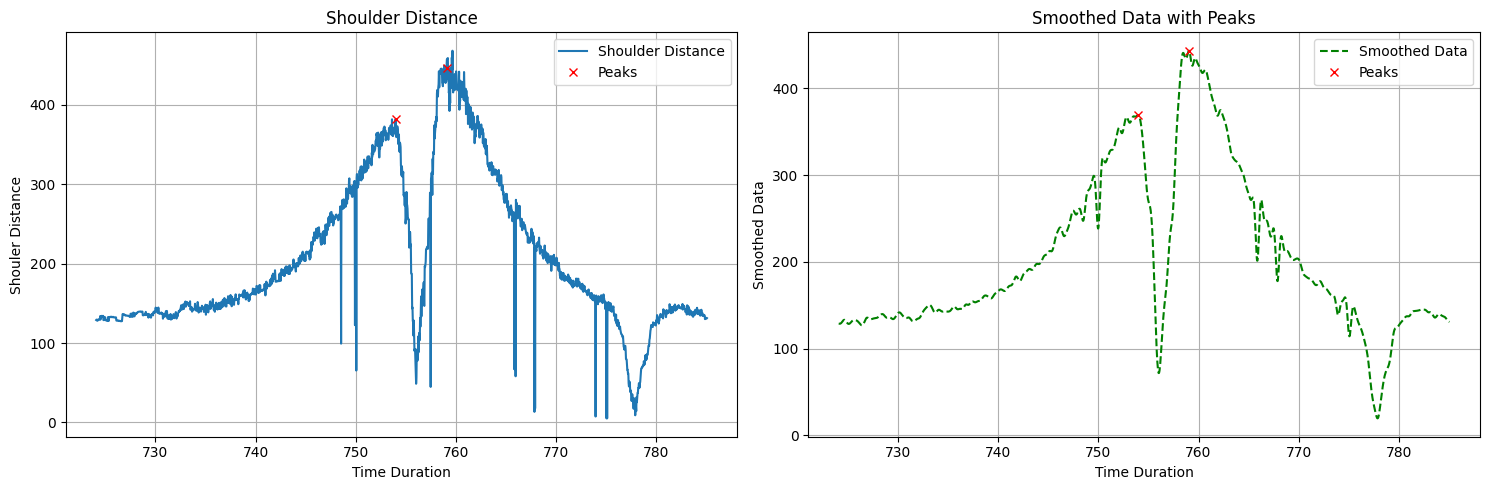

In [28]:
from scipy.signal import find_peaks
from scipy.signal import savgol_filter, butter, filtfilt
import matplotlib.pyplot as plt

# Butterworth low-pass filter function
def butter_lowpass(data, cutoff_frequency, sampling_rate, order=4):
    nyquist = 0.6 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Smooth the data using a Savitzky-Golay filter
smoothed_data_savgol = savgol_filter(sd, window_length=5, polyorder=2)

# Apply Butterworth low-pass filter to further smooth the data
cutoff_frequency = 5.0  # Adjust this value based on your requirements
sampling_rate = 2.5 / (turning_events['time_duration'].iloc[1] - turning_events['time_duration'].iloc[0])
smoothed_data_butter = butter_lowpass(smoothed_data_savgol, cutoff_frequency, sampling_rate)

# Find peaks in the smoothed data
peaks, _ = find_peaks(smoothed_data_butter, height=100, distance=100)  # Adjust height and distance as needed

# Limit the number of peaks to 2 and always get the highest points
if len(peaks) > 2:
    # # Get the indices of the two highest peaks
    highest_peaks_indices = peaks[np.argsort(smoothed_data_butter[peaks])[-2:]]
    # # Update the peaks array with the highest peaks indices
    peaks = highest_peaks_indices
    # first_peak_index = peaks[8]
    # fifth_peak_index = peaks[13]

    # # Update the peaks array with the indices of the first and fifth peaks
    # peaks = [first_peak_index, fifth_peak_index]

# Sort the peaks array
peaks = np.sort(peaks)

# Extract corresponding time values for the peaks
peaks_time = turning_events['time_duration'].iloc[peaks]

# Calculate the time duration between consecutive peaks
time_durations_between_peaks = np.diff(peaks_time)

# Print the time durations between peaks
print("Time Durations Between Peaks:", time_durations_between_peaks)

# Calculate the total time duration taken between peaks
total_time_duration = np.sum(time_durations_between_peaks)

# Print the total time duration
print("Total Time Duration Taken between Peaks:", total_time_duration)

# Plot the graphs side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the original data and the smoothed data
axes[0].plot(turning_events['time_duration'], sd, label='Shoulder Distance')
axes[0].plot(peaks_time, np.array(sd)[peaks], 'x', color='red', label='Peaks')
axes[0].set_title('Shoulder Distance')
axes[0].set_xlabel('Time Duration')
axes[0].set_ylabel('Shouler Distance')
axes[0].legend()
axes[0].grid(True)  # Add grid lines

# Plot the smoothed data with peaks
axes[1].plot(turning_events['time_duration'], smoothed_data_butter, label='Smoothed Data', linestyle='--', color='green')
axes[1].plot(peaks_time, np.array(smoothed_data_butter)[peaks], 'x', color='red', label='Peaks')
axes[1].set_title('Smoothed Data with Peaks')
axes[1].set_xlabel('Time Duration')
axes[1].set_ylabel('Smoothed Data')
axes[1].legend()
axes[1].grid(True)  # Add grid lines

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [29]:
# Extract data between peaks
data_between_peaks = turning_events.iloc[peaks[0]:peaks[-1]+1]

In [30]:
def calculate_step_length(LAnkle_x, LAnkle_y, RAnkle_x, RAnkle_y):
    """Calculate step length based on the Euclidean distance between ankles."""
    step_lengths = np.sqrt((RAnkle_x - LAnkle_x)**2 + (RAnkle_y - LAnkle_y)**2)
    return step_lengths

# Example usage:
LAnkle_x = data_between_peaks['LAnkle_x'].values
LAnkle_y = data_between_peaks['LAnkle_y'].values
RAnkle_x = data_between_peaks['RAnkle_x'].values
RAnkle_y = data_between_peaks['RAnkle_y'].values

step_lengths = calculate_step_length(LAnkle_x, LAnkle_y, RAnkle_x, RAnkle_y)

# Print or use the resulting step_lengths as needed
print("Step Lengths between Peaks:", np.mean(step_lengths))

Step Lengths between Peaks: 156.40529822870445


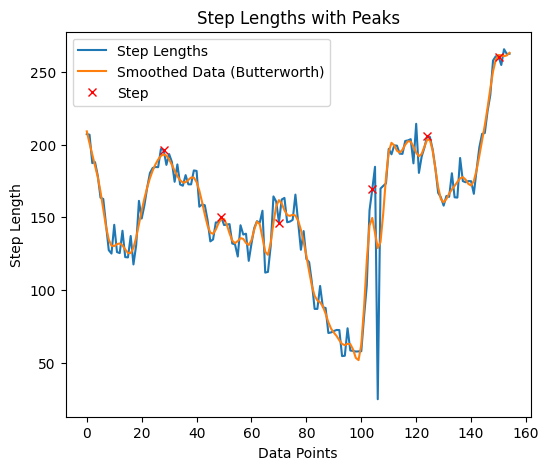

Number of step during turning body around: 6


In [31]:
# Smooth the data using a Savitzky-Golay filter
smoothed_data = savgol_filter(step_lengths, window_length=5, polyorder=2)
peaks1, _ = find_peaks(smoothed_data)

cutoff_frequency = 1.0  # Adjust this value based on your requirements
sampling_rate = 5.0
smoothed_data_butter_step_count = butter_lowpass(smoothed_data, cutoff_frequency, sampling_rate)

peaks1, _ = find_peaks(smoothed_data_butter_step_count, height=40, distance=20)

# Plot the graph with identified peaks
plt.figure(figsize=(6, 5))
plt.plot(step_lengths, label='Step Lengths')
plt.plot(smoothed_data_butter_step_count, label='Smoothed Data (Butterworth)')
plt.plot(peaks1, np.array(step_lengths)[peaks1], 'x', color='red', label='Step')
plt.title('Step Lengths with Peaks')
plt.xlabel('Data Points')
plt.ylabel('Step Length')
plt.legend()
plt.show()

# Count the number of waves
step_count = len(peaks1)
print("Number of step during turning body around:", step_count)

In [32]:
def calculate_stride_length(RAnkle_x, RAnkle_y):
    """Calculate step length based on the Euclidean distance between ankles."""
    stride_lengths = np.sqrt((RAnkle_x)**2 + (RAnkle_y)**2)
    return stride_lengths

RAnkle_x = data_between_peaks['RAnkle_x'].values
RAnkle_y = data_between_peaks['RAnkle_y'].values

stride_lengths = calculate_stride_length(RAnkle_x, RAnkle_y)
print("Mean Stride Lengths between Peaks:", np.mean(stride_lengths))

Mean Stride Lengths between Peaks: 1795.1284085254035


In [33]:
def calculate_knee_angle(LHip_x, LHip_y, LKnee_x, LKnee_y, LAnkle_x, LAnkle_y, RHip_x, RHip_y, RKnee_x, RKnee_y, RAnkle_x, RAnkle_y):
    # Calculate angle for the left knee
    left_angle = calculate_single_leg_angle(LHip_x, LHip_y, LKnee_x, LKnee_y, LAnkle_x, LAnkle_y)

    # Calculate angle for the right knee
    right_angle = calculate_single_leg_angle(RHip_x, RHip_y, RKnee_x, RKnee_y, RAnkle_x, RAnkle_y)

    return left_angle, right_angle

def calculate_single_leg_angle(Hip_x, Hip_y, Knee_x, Knee_y, Ankle_x, Ankle_y):
    # Compute vectors representing hip to knee and knee to ankle
    hip_to_knee_vector = np.array([Hip_x - Knee_x, Hip_y - Knee_y])
    knee_to_ankle_vector = np.array([Ankle_x - Knee_x, Ankle_y - Knee_y])

    # Calculate the dot product of hip-to-knee and knee-to-ankle vectors
    dot_product = np.sum(hip_to_knee_vector * knee_to_ankle_vector, axis=0)

    # Calculate the magnitude of hip-to-knee and knee-to-ankle vectors
    hip_to_knee_magnitude = np.linalg.norm(hip_to_knee_vector, axis=0)
    knee_to_ankle_magnitude = np.linalg.norm(knee_to_ankle_vector, axis=0)

    # Calculate the cosine of the angle between hip-to-knee and knee-to-ankle vectors
    cosine_angle = dot_product / (hip_to_knee_magnitude * knee_to_ankle_magnitude)

    # Calculate the angle in radians
    angle_radians = np.arccos(cosine_angle)

    # Convert radians to degrees
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees


In [34]:
LHip_x = data_between_peaks['LHip_x'].values
LHip_y = data_between_peaks['LHip_y'].values
RHip_x = data_between_peaks['RHip_x'].values
RHip_y = data_between_peaks['RHip_y'].values
LKnee_x = data_between_peaks['LKnee_x'].values
LKnee_y = data_between_peaks['LKnee_y'].values
RKnee_x = data_between_peaks['Rknee_x'].values
RKnee_y = data_between_peaks['Rknee_y'].values
LAnkle_x = data_between_peaks['LAnkle_x'].values
LAnkle_y = data_between_peaks['LAnkle_y'].values
RAnkle_x = data_between_peaks['RAnkle_x'].values
RAnkle_y = data_between_peaks['RAnkle_y'].values

left_angle, right_angle = calculate_knee_angle(LHip_x, LHip_y, LKnee_x, LKnee_y, LAnkle_x, LAnkle_y, RHip_x, RHip_y, RKnee_x, RKnee_y, RAnkle_x, RAnkle_y)

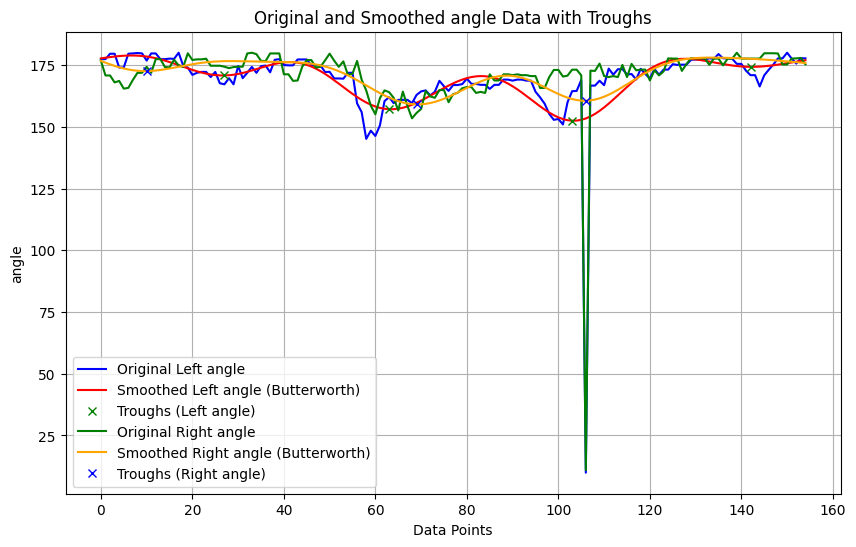

Smallest peak value in Left Knee angle:: 152.46750060533276
Smallest peak value in Right Knee angle: 159.07266885405107


In [35]:
from scipy.signal import butter, filtfilt, find_peaks

def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


if len(data_between_peaks) > 80 :
  sampling_rate = 30.0
else:
  sampling_rate = 10.0

# Parameters for Butterworth filter and trough detection
cutoff_frequency = 1.0  # Adjust this value based on your requirements


# Apply Butterworth filter to left angle data
smoothed_left_angle = butter_lowpass_filter(left_angle, cutoff_frequency, sampling_rate)

# Apply Butterworth filter to right angle data
smoothed_right_angle = butter_lowpass_filter(right_angle, cutoff_frequency, sampling_rate)

# Find troughs (valleys) in the smoothed left angle data
left_angle_troughs, _ = find_peaks(-smoothed_left_angle)

# Find troughs (valleys) in the smoothed right angle data
right_angle_troughs, _ = find_peaks(-smoothed_right_angle)

# Plot the original and smoothed angle data with detected troughs
plt.figure(figsize=(10, 6))
plt.plot(left_angle, label='Original Left angle', color='blue')
plt.plot(smoothed_left_angle, label='Smoothed Left angle (Butterworth)', color='red')
plt.plot(left_angle_troughs, smoothed_left_angle[left_angle_troughs], 'x', color='green', label='Troughs (Left angle)')
plt.plot(right_angle, label='Original Right angle', color='green')
plt.plot(smoothed_right_angle, label='Smoothed Right angle (Butterworth)', color='orange')
plt.plot(right_angle_troughs, smoothed_right_angle[right_angle_troughs], 'x', color='blue', label='Troughs (Right angle)')
plt.title('Original and Smoothed angle Data with Troughs')
plt.xlabel('Data Points')
plt.ylabel('angle')
plt.legend()
plt.grid(True)
plt.show()

print("Smallest peak value in Left Knee angle::", np.min(smoothed_left_angle[left_angle_troughs]))
print("Smallest peak value in Right Knee angle:", np.min(smoothed_right_angle[right_angle_troughs]))

#Hip angle

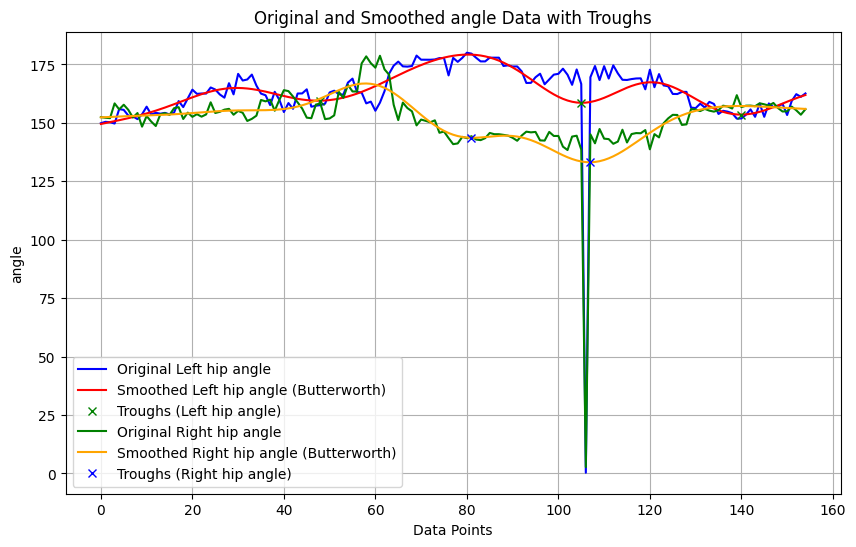

Left Hip Angle 153.53186545705543
Right Hip Angle 133.13883098611046


In [36]:
def calculate_hip_rom(LHip_x, LHip_y, LKnee_x, LKnee_y, LShoulder_x, LShoulder_y, RHip_x, RHip_y, RKnee_x, RKnee_y, RShoulder_x, RShoulder_y):

    # Calculate shoulder midpoint
    Shoulder_midpoint_x = (RShoulder_x + LShoulder_x) / 2
    Shoulder_midpoint_y = (RShoulder_y + LShoulder_y) / 2

    # Calculate ROM for the left knee
    left_hip = calculate_single_hip(LHip_x, LHip_y, LKnee_x, LKnee_y, Shoulder_midpoint_x, Shoulder_midpoint_y)

    # Calculate ROM for the right knee
    right_hip = calculate_single_hip(RHip_x, RHip_y, RKnee_x, RKnee_y, Shoulder_midpoint_x, Shoulder_midpoint_y)

    return left_hip, right_hip

def calculate_single_hip(Hip_x, Hip_y, Knee_x, Knee_y, Shoulder_x, Shoulder_y):
    # Compute vectors representing hip to knee and knee to shoulder
    hip_to_knee_vector = np.array([Shoulder_x - Hip_x, Shoulder_x - Hip_y])
    knee_to_shoulder_vector = np.array([Knee_x - Hip_x, Knee_y - Hip_y])

    # Calculate the dot product of hip-to-knee and knee-to-shoulder vectors
    dot_product = np.sum(hip_to_knee_vector * knee_to_shoulder_vector, axis=0)

    # Calculate the magnitude of hip-to-knee and knee-to-shoulder vectors
    hip_to_knee_magnitude = np.linalg.norm(hip_to_knee_vector, axis=0)
    knee_to_shoulder_magnitude = np.linalg.norm(knee_to_shoulder_vector, axis=0)

    # Calculate the cosine of the angle between hip-to-knee and knee-to-shoulder vectors
    cosine_angle = dot_product / (hip_to_knee_magnitude * knee_to_shoulder_magnitude)

    # Calculate the angle in radians
    angle_radians = np.arccos(cosine_angle)

    # Convert radians to degrees
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

LShoulder_x = data_between_peaks['LShoulder_x'].values
LShoulder_y = data_between_peaks['LShoulder_y'].values
RShoulder_x = data_between_peaks['RShoulder_x'].values
RShoulder_y = data_between_peaks['RShoulder_y'].values

left_hip, right_hip = calculate_hip_rom(LHip_x, LHip_y, LKnee_x, LKnee_y, LShoulder_x, LShoulder_y, RHip_x, RHip_y, RKnee_x, RKnee_y, RShoulder_x, RShoulder_y)

# Apply Butterworth filter to left angle data
smoothed_left_hip_angle = butter_lowpass_filter(left_hip, cutoff_frequency, sampling_rate)

# Apply Butterworth filter to right angle data
smoothed_right_hip_angle = butter_lowpass_filter(right_hip, cutoff_frequency, sampling_rate)

# Find troughs (valleys) in the smoothed left angle data
left_hip_angle_troughs, _ = find_peaks(-smoothed_left_hip_angle)

# Find troughs (valleys) in the smoothed right angle data
right_hip_angle_troughs, _ = find_peaks(-smoothed_right_hip_angle)

# Plot the original and smoothed angle data with detected troughs
plt.figure(figsize=(10, 6))
plt.plot(left_hip, label='Original Left hip angle', color='blue')
plt.plot(smoothed_left_hip_angle, label='Smoothed Left hip angle (Butterworth)', color='red')
plt.plot(left_hip_angle_troughs, smoothed_left_hip_angle[left_hip_angle_troughs], 'x', color='green', label='Troughs (Left hip angle)')
plt.plot(right_hip, label='Original Right hip angle', color='green')
plt.plot(smoothed_right_hip_angle, label='Smoothed Right hip angle (Butterworth)', color='orange')
plt.plot(right_hip_angle_troughs, smoothed_right_hip_angle[right_hip_angle_troughs], 'x', color='blue', label='Troughs (Right hip angle)')
plt.title('Original and Smoothed angle Data with Troughs')
plt.xlabel('Data Points')
plt.ylabel('angle')
plt.legend()
plt.grid(True)
plt.show()

print("Left Hip Angle", np.min(smoothed_left_hip_angle[left_hip_angle_troughs]))
print("Right Hip Angle", np.min(smoothed_right_hip_angle[right_hip_angle_troughs]))

#Leg Symmetric

In [37]:
def calculate_leg_symmetric(LHip_x, LHip_y, LKnee_x, LKnee_y, RHip_x, RHip_y, RKnee_x, RKnee_y):
    # Calculate hip midpoint
    Hip_midpoint_x = (RHip_x + LHip_x) / 2
    Hip_midpoint_y = (RHip_y + LHip_y) / 2

    # Calculate ankle midpoint
    Knee_midpoint_x = (RKnee_x + LKnee_x) / 2
    Knee_midpoint_y = (RKnee_y + LKnee_y) / 2

    # Calculate ROM for the left leg
    left_rom = calculate_single_leg_symmetric(Knee_midpoint_x, Knee_midpoint_y, Hip_midpoint_x, Hip_midpoint_y, LKnee_x, LKnee_y)

    # Calculate ROM for the right leg
    right_rom = calculate_single_leg_symmetric(Knee_midpoint_x, Knee_midpoint_y, Hip_midpoint_x, Hip_midpoint_y, RKnee_x, RKnee_y)

    return left_rom, right_rom

def calculate_single_leg_symmetric(Knee_midpoint_x, Knee_midpoint_y, Hip_midpoint_x, Hip_midpoint_y, Knee_x, Knee_y):

    # Compute vectors representing hip to ankle midpoint and ankle midpoint to hip midpoint
    knee_to_hip_midpoint_vector = np.array([Knee_x - Hip_midpoint_x, Knee_y - Hip_midpoint_y])
    knee_midpoint_to_hip_midpoint_vector = np.array([Knee_midpoint_x - Hip_midpoint_x,  Knee_midpoint_y - Hip_midpoint_y])

    # Calculate the dot product of hip-to-ankle midpoint and ankle midpoint-to-hip midpoint vectors
    dot_product = np.sum(knee_to_hip_midpoint_vector * knee_midpoint_to_hip_midpoint_vector, axis=0)

    # Calculate the magnitude of hip-to-ankle midpoint and ankle midpoint-to-hip midpoint vectors
    hip_to_knee_midpoint_magnitude = np.linalg.norm(knee_to_hip_midpoint_vector, axis=0)
    knee_midpoint_to_hip_midpoint_magnitude = np.linalg.norm(knee_midpoint_to_hip_midpoint_vector, axis=0)

    # Calculate the cosine of the angle between hip-to-ankle midpoint and ankle midpoint-to-hip midpoint vectors
    cosine_angle = dot_product / (hip_to_knee_midpoint_magnitude * knee_midpoint_to_hip_midpoint_magnitude)

    # Calculate the angle in radians
    angle_radians = np.arccos(cosine_angle)

    # Convert radians to degrees
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees


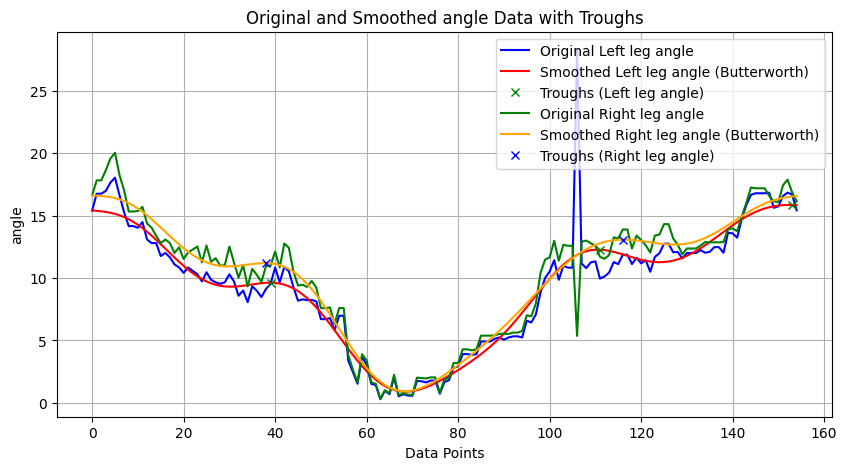

Symmetric Range of Motion (degrees) of Left Leg: 15.868902968044923
Symmetric Range of Motion (degrees) of Right Leg: 13.078746070811423
Symmetric Leg Level: 0


In [38]:
left_rom1, right_rom1 = calculate_leg_symmetric(LHip_x, LHip_y, LKnee_x, LKnee_y, RHip_x, RHip_y, RKnee_x, RKnee_y)

for i in range(1, len(left_rom1)):
    if np.isnan(left_rom1[i]):
        left_rom1[i] = left_rom1[i - 1]

for i in range(1, len(right_rom1)):
    if np.isnan(right_rom1[i]):
        right_rom1[i] = right_rom1[i - 1]

# Replace NaN values in right_rom1 with the previous valid data points
right_rom1 = np.nan_to_num(right_rom1, nan=np.nan, posinf=None, neginf=None)

# Apply Butterworth filter to left angle data
smoothed_left_leg_angle = butter_lowpass_filter(left_rom1, cutoff_frequency, sampling_rate)

# Apply Butterworth filter to right angle data
smoothed_right_leg_angle = butter_lowpass_filter(right_rom1, cutoff_frequency, sampling_rate)

# Find troughs (valleys) in the smoothed left angle data
left_leg_angle_troughs, _ = find_peaks(smoothed_left_leg_angle)

# Find troughs (valleys) in the smoothed right angle data
right_leg_angle_troughs, _ = find_peaks(smoothed_right_leg_angle)

# Plot the original and smoothed angle data with detected troughs
plt.figure(figsize=(10, 5))
plt.plot(left_rom1, label='Original Left leg angle', color='blue')
plt.plot(smoothed_left_leg_angle, label='Smoothed Left leg angle (Butterworth)', color='red')
plt.plot(left_leg_angle_troughs, smoothed_left_leg_angle[left_leg_angle_troughs], 'x', color='green', label='Troughs (Left leg angle)')
plt.plot(right_rom1, label='Original Right leg angle', color='green')
plt.plot(smoothed_right_leg_angle, label='Smoothed Right leg angle (Butterworth)', color='orange')
plt.plot(right_leg_angle_troughs, smoothed_right_leg_angle[right_leg_angle_troughs], 'x', color='blue', label='Troughs (Right leg angle)')
plt.title('Original and Smoothed angle Data with Troughs')
plt.xlabel('Data Points')
plt.ylabel('angle')
plt.legend()
plt.grid(True)
plt.show()

max_left = max(smoothed_left_leg_angle[left_leg_angle_troughs])
max_right = max(smoothed_right_leg_angle[right_leg_angle_troughs])
difference = abs(max_left - max_right)

if 1 > difference:
  symmetric = 1
elif 2 > difference > 1:
  symmetric = 0.5
elif difference > 2:
  symmetric = 0

print("Symmetric Range of Motion (degrees) of Left Leg:", max_left)
print("Symmetric Range of Motion (degrees) of Right Leg:", max_right)
print("Symmetric Leg Level:", symmetric)

# Symmetric arm swing

In [39]:
def calculate_arm_symmetric(LShoulder_x, LShoulder_y, LElbow_x, LElbow_y, RShoulder_x, RShoulder_y, RElbow_x, RElbow_y):
    # Calculate Shoulder midpoint
    Shoulder_midpoint_x = (RShoulder_x + LShoulder_x) / 2
    Shoulder_midpoint_y = (RShoulder_y + LShoulder_y) / 2

    # Calculate ankle midpoint
    Elbow_midpoint_x = (RElbow_x + LElbow_x) / 2
    Elbow_midpoint_y = (RElbow_y + LElbow_y) / 2

    # Calculate ROM for the left arm
    left_rom = calculate_single_arm_symmetric(Elbow_midpoint_x, Elbow_midpoint_y, Shoulder_midpoint_x, Shoulder_midpoint_y, LElbow_x, LElbow_y)

    # Calculate ROM for the right arm
    right_rom = calculate_single_arm_symmetric(Elbow_midpoint_x, Elbow_midpoint_y, Shoulder_midpoint_x, Shoulder_midpoint_y, RElbow_x, RElbow_y)

    return left_rom, right_rom

def calculate_single_arm_symmetric(Elbow_midpoint_x, Elbow_midpoint_y, Shoulder_midpoint_x, Shoulder_midpoint_y, Elbow_x, Elbow_y):

    # Compute vectors representing Shoulder to ankle midpoint and ankle midpoint to Shoulder midpoint
    Elbow_to_Shoulder_midpoint_vector = np.array([Elbow_x - Shoulder_midpoint_x, Elbow_y - Shoulder_midpoint_y])
    Elbow_midpoint_to_Shoulder_midpoint_vector = np.array([Elbow_midpoint_x - Shoulder_midpoint_x,  Elbow_midpoint_y - Shoulder_midpoint_y])

    # Calculate the dot product of Shoulder-to-ankle midpoint and ankle midpoint-to-Shoulder midpoint vectors
    dot_product = np.sum(Elbow_to_Shoulder_midpoint_vector * Elbow_midpoint_to_Shoulder_midpoint_vector, axis=0)

    # Calculate the magnitude of Shoulder-to-ankle midpoint and ankle midpoint-to-Shoulder midpoint vectors
    Shoulder_to_Elbow_midpoint_magnitude = np.linalg.norm(Elbow_to_Shoulder_midpoint_vector, axis=0)
    Elbow_midpoint_to_Shoulder_midpoint_magnitude = np.linalg.norm(Elbow_midpoint_to_Shoulder_midpoint_vector, axis=0)

    # Calculate the cosine of the angle between Shoulder-to-ankle midpoint and ankle midpoint-to-Shoulder midpoint vectors
    cosine_angle = dot_product / (Shoulder_to_Elbow_midpoint_magnitude * Elbow_midpoint_to_Shoulder_midpoint_magnitude)

    # Calculate the angle in radians
    angle_radians = np.arccos(cosine_angle)

    # Convert radians to degrees
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

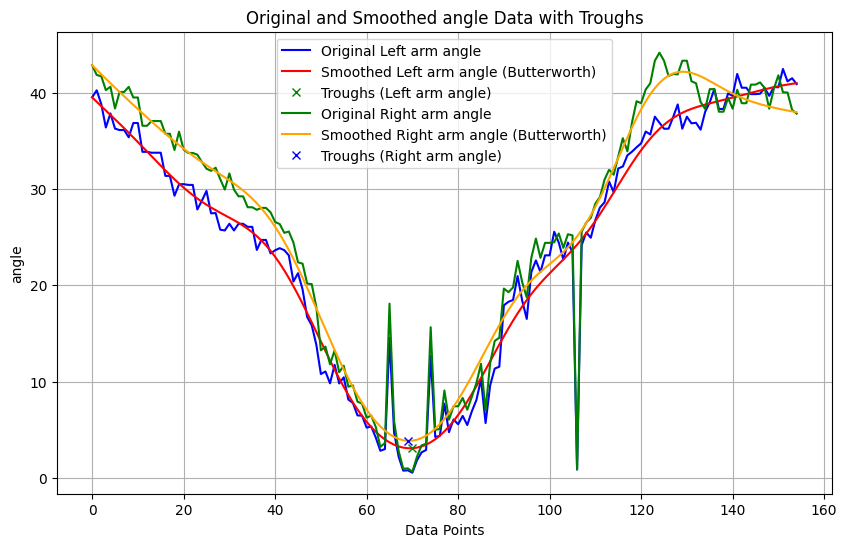

Symmetric Range of Motion (degrees) of Left Arm: 3.0755154700127165
Symmetric Range of Motion (degrees) of Right Arm: 3.8454455399264513
Symmetric Level: 1


In [40]:
LElbow_x = data_between_peaks['LElbow_x'].values
LElbow_y = data_between_peaks['LElbow_y'].values
RElbow_x = data_between_peaks['RElbow_x'].values
RElbow_y = data_between_peaks['RElbow_y'].values

left_rom2, right_rom2 = calculate_arm_symmetric(LShoulder_x, LShoulder_y, LElbow_x, LElbow_y, RShoulder_x, RShoulder_y, RElbow_x, RElbow_y)

for i in range(1, len(left_rom2)):
    if np.isnan(left_rom2[i]):
        left_rom2[i] = left_rom2[i - 1]

for i in range(1, len(right_rom2)):
    if np.isnan(right_rom2[i]):
        right_rom2[i] = right_rom2[i - 1]

# Apply Butterworth filter to left angle data
smoothed_left_arm_angle = butter_lowpass_filter(left_rom2, cutoff_frequency, sampling_rate)

# Apply Butterworth filter to right angle data
smoothed_right_arm_angle = butter_lowpass_filter(right_rom2, cutoff_frequency, sampling_rate)

# Find troughs (valleys) in the smoothed left angle data
left_arm_angle_troughs, _ = find_peaks(-smoothed_left_arm_angle)

# Find troughs (valleys) in the smoothed right angle data
right_arm_angle_troughs, _ = find_peaks(-smoothed_right_arm_angle)

# Plot the original and smoothed angle data with detected troughs
plt.figure(figsize=(10, 6))
plt.plot(left_rom2, label='Original Left arm angle', color='blue')
plt.plot(smoothed_left_arm_angle, label='Smoothed Left arm angle (Butterworth)', color='red')
plt.plot(left_arm_angle_troughs, smoothed_left_arm_angle[left_arm_angle_troughs], 'x', color='green', label='Troughs (Left arm angle)')
plt.plot(right_rom2, label='Original Right arm angle', color='green')
plt.plot(smoothed_right_arm_angle, label='Smoothed Right arm angle (Butterworth)', color='orange')
plt.plot(right_arm_angle_troughs, smoothed_right_arm_angle[right_arm_angle_troughs], 'x', color='blue', label='Troughs (Right arm angle)')
plt.title('Original and Smoothed angle Data with Troughs')
plt.xlabel('Data Points')
plt.ylabel('angle')
plt.legend()
plt.grid(True)
plt.show()

max_left1 = min(smoothed_left_arm_angle[left_arm_angle_troughs])
max_right1 = min(smoothed_right_arm_angle[right_arm_angle_troughs])
difference1 = abs(max_left1 - max_right1)

if 1 > difference1:
  symmetric1 = 1
elif 2 > difference1 > 1:
  symmetric1 = 0.5
elif difference1 > 2:
  symmetric1 = 0

print("Symmetric Range of Motion (degrees) of Left Arm:", max_left1)
print("Symmetric Range of Motion (degrees) of Right Arm:", max_right1)
print("Symmetric Level:", symmetric1)

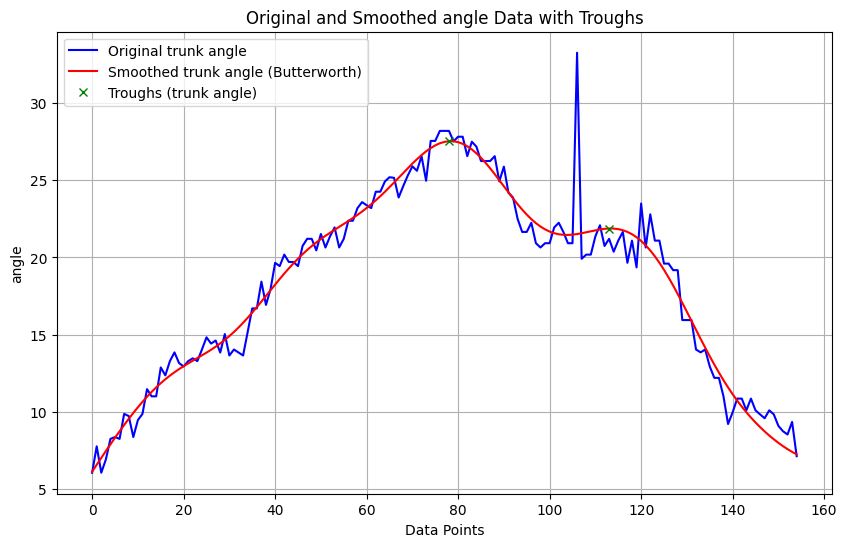

Trunk angles (in degrees): 27.534758595040802


In [41]:
def calculate_trunk_angle(LHip_x, LHip_y, RHip_x, RHip_y, Nose_x, Nose_y):

    Hip_midpoint_x = (RHip_x + LHip_x) / 2
    Hip_midpoint_y = (RHip_y + LHip_y) / 2

    hip_vector = np.array([Hip_midpoint_x - Hip_midpoint_x,  (Hip_midpoint_y - 10) - Hip_midpoint_y])
    nose_vector = np.array([Nose_x - Hip_midpoint_x,  Nose_y - Hip_midpoint_y])

    dot_product = np.sum(hip_vector * nose_vector, axis=0)

    hip_norm = np.linalg.norm(hip_vector, axis=0)
    nose_norm = np.linalg.norm(nose_vector, axis=0)

    cosine_angle = dot_product / (hip_norm * nose_norm)

    # Calculate the angle in radians
    trunk_angle = np.arccos(cosine_angle)

    angle_degrees = np.degrees(trunk_angle)

    return angle_degrees

Nose_x = data_between_peaks['Nose_x'].values
Nose_y = data_between_peaks['Nose_y'].values

trunk_angles_degrees = calculate_trunk_angle(LHip_x, LHip_y, RHip_x, RHip_y, Nose_x, Nose_y)

# Apply Butterworth filter to left angle data
smoothed_trunk_angle = butter_lowpass_filter(trunk_angles_degrees, cutoff_frequency, sampling_rate)

# Find troughs (valleys) in the smoothed right angle data
trunk_angle_troughs, _ = find_peaks(smoothed_trunk_angle)

# Plot the original and smoothed angle data with detected troughs
plt.figure(figsize=(10, 6))
plt.plot(trunk_angles_degrees, label='Original trunk angle', color='blue')
plt.plot(smoothed_trunk_angle, label='Smoothed trunk angle (Butterworth)', color='red')
plt.plot(trunk_angle_troughs, smoothed_trunk_angle[trunk_angle_troughs], 'x', color='green', label='Troughs (trunk angle)')
plt.title('Original and Smoothed angle Data with Troughs')
plt.xlabel('Data Points')
plt.ylabel('angle')
plt.legend()
plt.grid(True)
plt.show()

print("Trunk angles (in degrees):", max(smoothed_trunk_angle[trunk_angle_troughs]))

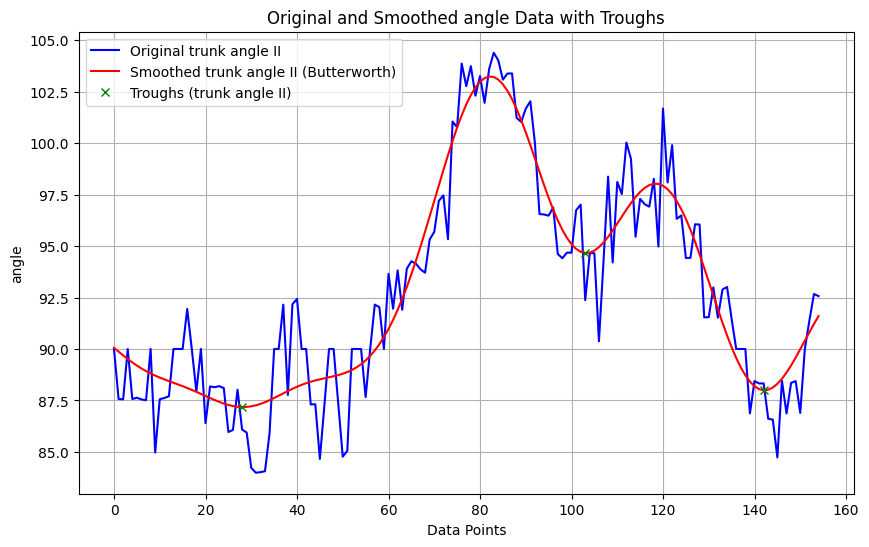

Trunk angles II (in degrees): 87.1798937237861


In [42]:
def calculate_trunk_angle2(LShoulder_x, LShoulder_y, RShoulder_x, RShoulder_y, LHip_x, LHip_y, RHip_x, RHip_y):

    Hip_midpoint_x = (RHip_x + LHip_x) / 2
    Hip_midpoint_y = (RHip_y + LHip_y) / 2

    Shoulder_midpoint_x = (RShoulder_x + LShoulder_x) / 2
    Shoudler_midpoint_y = (RShoulder_x + LShoulder_x) / 2

    hip_vector = np.array([Shoulder_midpoint_x - Hip_midpoint_x,  Shoudler_midpoint_y - Hip_midpoint_y])
    nose_vector = np.array([(Hip_midpoint_x + 10) - Hip_midpoint_x,  Hip_midpoint_y - Hip_midpoint_y])

    dot_product = np.sum(hip_vector * nose_vector, axis=0)

    hip_norm = np.linalg.norm(hip_vector, axis=0)
    nose_norm = np.linalg.norm(nose_vector, axis=0)

    cosine_angle = dot_product / (hip_norm * nose_norm)

    # Calculate the angle in radians
    trunk_angle = np.arccos(cosine_angle)

    angle_degrees = np.degrees(trunk_angle)

    return angle_degrees

trunk_angles_degrees2 = calculate_trunk_angle2(LShoulder_x, LShoulder_y, RShoulder_x, RShoulder_y, LHip_x, LHip_y, RHip_x, RHip_y)

# Apply Butterworth filter to left angle data
smoothed_trunk_angle1 = butter_lowpass_filter(trunk_angles_degrees2, cutoff_frequency, sampling_rate)

# Find troughs (valleys) in the smoothed right angle data
trunk_angle_troughs1, _ = find_peaks(-smoothed_trunk_angle1)

# Plot the original and smoothed angle data with detected troughs
plt.figure(figsize=(10, 6))
plt.plot(trunk_angles_degrees2, label='Original trunk angle II', color='blue')
plt.plot(smoothed_trunk_angle1, label='Smoothed trunk angle II (Butterworth)', color='red')
plt.plot(trunk_angle_troughs1, smoothed_trunk_angle1[trunk_angle_troughs1], 'x', color='green', label='Troughs (trunk angle II)')
plt.title('Original and Smoothed angle Data with Troughs')
plt.xlabel('Data Points')
plt.ylabel('angle')
plt.legend()
plt.grid(True)
plt.show()

print("Trunk angles II (in degrees):", min(smoothed_trunk_angle1[trunk_angle_troughs1]))

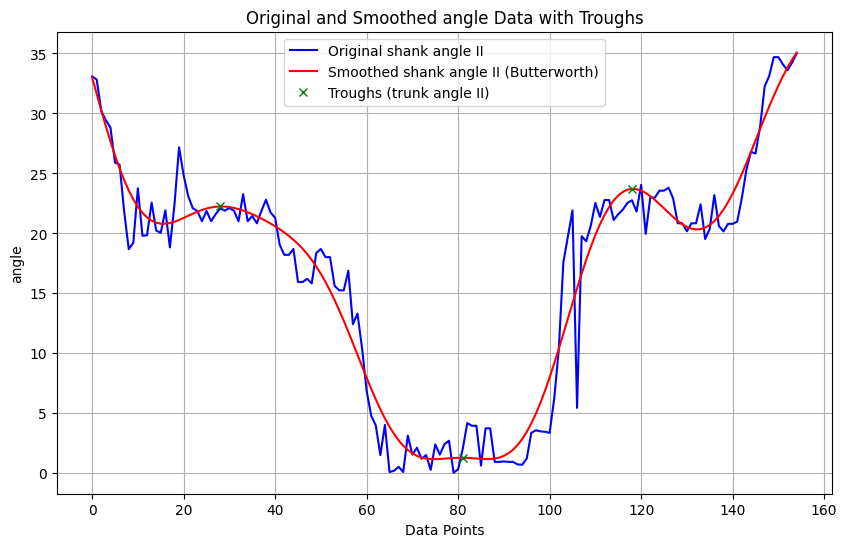

Shank angle: 23.71430329631052


In [43]:
def calculate_angle_knee_midpoint_to_leg(LKnee_x, LKnee_y, RKnee_x, RKnee_y, LAnkle_x, LAnkle_y, RAnkle_x, RAnkle_y):

    # Calculate midpoint between left and right knees
    MidKnee_x = (LKnee_x + RKnee_x) / 2
    MidKnee_y = (LKnee_y + RKnee_y) / 2

    vector1 = np.array([LAnkle_x - MidKnee_x, LAnkle_y - MidKnee_y])
    vector2 = np.array([RAnkle_x - MidKnee_x, RAnkle_y - MidKnee_y])

    # Calculate the dot product of hip-to-knee and knee-to-ankle vectors
    dot_product = np.sum(vector1 * vector2, axis=0)

    # Calculate the magnitude of hip-to-knee and knee-to-ankle vectors
    ankle_to_knee_magnitude = np.linalg.norm(vector1, axis=0)
    knee_to_ankle_magnitude = np.linalg.norm(vector2, axis=0)

    # Calculate the cosine of the angle between hip-to-knee and knee-to-ankle vectors
    cosine_angle = dot_product / (ankle_to_knee_magnitude * knee_to_ankle_magnitude)

    # Calculate the angle in radians
    angle_radians = np.arccos(cosine_angle)

    # Convert radians to degrees
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

shank_angle = calculate_angle_knee_midpoint_to_leg(LKnee_x, LKnee_y, RKnee_x, RKnee_y, LAnkle_x, LAnkle_y, RAnkle_x, RAnkle_y)

for i in range(1, len(shank_angle)):
    if np.isnan(shank_angle[i]):
        shank_angle[i] = shank_angle[i - 1]

# Apply Butterworth filter to left angle data
smoothed_shank_angle = butter_lowpass_filter(shank_angle, cutoff_frequency, sampling_rate)

# Find troughs (valleys) in the smoothed right angle data
shank_angle_troughs, _ = find_peaks(smoothed_shank_angle)

# Plot the original and smoothed angle data with detected troughs
plt.figure(figsize=(10, 6))
plt.plot(shank_angle, label='Original shank angle II', color='blue')
plt.plot(smoothed_shank_angle, label='Smoothed shank angle II (Butterworth)', color='red')
plt.plot(shank_angle_troughs, smoothed_shank_angle[shank_angle_troughs], 'x', color='green', label='Troughs (trunk angle II)')
plt.title('Original and Smoothed angle Data with Troughs')
plt.xlabel('Data Points')
plt.ylabel('angle')
plt.legend()
plt.grid(True)
plt.show()

print("Shank angle:", max(smoothed_shank_angle[shank_angle_troughs]))

In [44]:
print(total_time_duration)
print("Step Lengths between Peaks:", np.mean(step_lengths))
print("Number of step during turning body around:", step_count)
print("Mean Stride Lengths between Peaks:", np.mean(stride_lengths))
print("Smallest peak value in Left Knee angle::", np.min(smoothed_left_angle[left_angle_troughs]))
print("Smallest peak value in Right Knee angle:", np.min(smoothed_right_angle[right_angle_troughs]))
print("Left Hip Angle", np.min(smoothed_left_hip_angle[left_hip_angle_troughs]))
print("Right Hip Angle", np.min(smoothed_right_hip_angle[right_hip_angle_troughs]))
print("Symmetric Range of Motion (degrees) of Left Leg:", max_left)
print("Symmetric Range of Motion (degrees) of Right Leg:", max_right)
print("Symmetric Leg Level:", symmetric)
print("Symmetric Range of Motion (degrees) of Left Arm:", max_left1)
print("Symmetric Range of Motion (degrees) of Right Arm:", max_right1)
print("Symmetric Level:", symmetric1)
print("Trunk angles (vertical):", max(smoothed_trunk_angle[trunk_angle_troughs]))
print("Trunk angles II (horizontal):", min(smoothed_trunk_angle1[trunk_angle_troughs1]))
print("Shank angle:", max(smoothed_shank_angle[shank_angle_troughs]))

5.080584099513203
Step Lengths between Peaks: 156.40529822870445
Number of step during turning body around: 6
Mean Stride Lengths between Peaks: 1795.1284085254035
Smallest peak value in Left Knee angle:: 152.46750060533276
Smallest peak value in Right Knee angle: 159.07266885405107
Left Hip Angle 153.53186545705543
Right Hip Angle 133.13883098611046
Symmetric Range of Motion (degrees) of Left Leg: 15.868902968044923
Symmetric Range of Motion (degrees) of Right Leg: 13.078746070811423
Symmetric Leg Level: 0
Symmetric Range of Motion (degrees) of Left Arm: 3.0755154700127165
Symmetric Range of Motion (degrees) of Right Arm: 3.8454455399264513
Symmetric Level: 1
Trunk angles (vertical): 27.534758595040802
Trunk angles II (horizontal): 87.1798937237861
Shank angle: 23.71430329631052


In [45]:
# # import matplotlib.pyplot as plt


# # Extract first row from each set of coordinates
# Nose_first = data_between_peaks.iloc[0][['Nose_x', 'Nose_y']]
# LEye_first = data_between_peaks.iloc[0][['LEye_x', 'LEye_y']]
# REye_first = data_between_peaks.iloc[0][['REye_x', 'REye_y']]
# LEar_first = data_between_peaks.iloc[0][['LEar_x', 'LEar_y']]
# REar_first = data_between_peaks.iloc[0][['REar_x', 'REar_y']]
# LShoulder_first = data_between_peaks.iloc[0][['LShoulder_x', 'LShoulder_y']]
# RShoulder_first = data_between_peaks.iloc[0][['RShoulder_x', 'RShoulder_y']]
# LElbow_first = data_between_peaks.iloc[0][['LElbow_x', 'LElbow_y']]
# RElbow_first = data_between_peaks.iloc[0][['RElbow_x', 'RElbow_y']]
# LWrist_first = data_between_peaks.iloc[0][['LWrist_x', 'LWrist_y']]
# RWrist_first = data_between_peaks.iloc[0][['RWrist_x', 'RWrist_y']]
# LHip_first = data_between_peaks.iloc[0][['LHip_x', 'LHip_y']]
# RHip_first = data_between_peaks.iloc[0][['RHip_x', 'RHip_y']]
# LKnee_first = data_between_peaks.iloc[0][['LKnee_x', 'LKnee_y']]
# RKnee_first = data_between_peaks.iloc[0][['Rknee_x', 'Rknee_y']]
# LAnkle_first = data_between_peaks.iloc[0][['LAnkle_x', 'LAnkle_y']]
# RAnkle_first = data_between_peaks.iloc[0][['RAnkle_x', 'RAnkle_y']]

# # Plot the first element of each set of coordinates
# plt.figure(figsize=(10, 15))
# plt.plot(Nose_first['Nose_x'], Nose_first['Nose_y'], 'bo', label='Nose')
# plt.plot(LEye_first['LEye_x'], LEye_first['LEye_y'], 'go', label='Left Eye')
# plt.plot(REye_first['REye_x'], REye_first['REye_y'], 'ro', label='Right Eye')
# plt.plot(LEar_first['LEar_x'], LEar_first['LEar_y'], 'mo', label='Left Ear')
# plt.plot(REar_first['REar_x'], REar_first['REar_y'], 'co', label='Right Ear')
# plt.plot(LShoulder_first['LShoulder_x'], LShoulder_first['LShoulder_y'], 'yo', label='Left Shoulder')
# plt.plot(RShoulder_first['RShoulder_x'], RShoulder_first['RShoulder_y'], 'ko', label='Right Shoulder')
# plt.plot(LElbow_first['LElbow_x'], LElbow_first['LElbow_y'], 'bx', label='Left Elbow')
# plt.plot(RElbow_first['RElbow_x'], RElbow_first['RElbow_y'], 'gx', label='Right Elbow')
# plt.plot(LWrist_first['LWrist_x'], LWrist_first['LWrist_y'], 'rx', label='Left Wrist')
# plt.plot(RWrist_first['RWrist_x'], RWrist_first['RWrist_y'], 'mx', label='Right Wrist')
# plt.plot(LHip_first['LHip_x'], LHip_first['LHip_y'], 'cx', label='Left Hip')
# plt.plot(RHip_first['RHip_x'], RHip_first['RHip_y'], 'yx', label='Right Hip')
# plt.plot(LKnee_first['LKnee_x'], LKnee_first['LKnee_y'], 'bx', label='Left Knee')
# plt.plot(RKnee_first['Rknee_x'], RKnee_first['Rknee_y'], 'gx', label='Right Knee')
# plt.plot(LAnkle_first['LAnkle_x'], LAnkle_first['LAnkle_y'], 'rx', label='Left Ankle')
# plt.plot(RAnkle_first['RAnkle_x'], RAnkle_first['RAnkle_y'], 'mx', label='Right Ankle')

# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Facial keypoints and body joint coordinates of the first data point')
# plt.legend()
# plt.grid(True)
# plt.show()